In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
url = "https://raw.githubusercontent.com/wisabd/MLOps-Hands-on/main/CreditScoring.csv"
Data = pd.read_csv(url)

# Verify the data
Data.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [80]:
# Calculate percentage distribution
category_percentages = df['Home'].value_counts(normalize=True) * 100

# Display with formatting
print(category_percentages.round(2).astype(str) + '%')

Home
2     47.3%
1    21.84%
5    17.58%
6     7.16%
3     5.54%
4     0.45%
0     0.13%
Name: proportion, dtype: object


In [81]:
print(Data.columns)

Index(['Status', 'Seniority', 'Home', 'Time', 'Age', 'Marital', 'Records',
       'Job', 'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price'],
      dtype='object')


In [82]:
# Spearman correlation (robust to non-linearity)
corr_matrix = Data.corr(method='spearman')


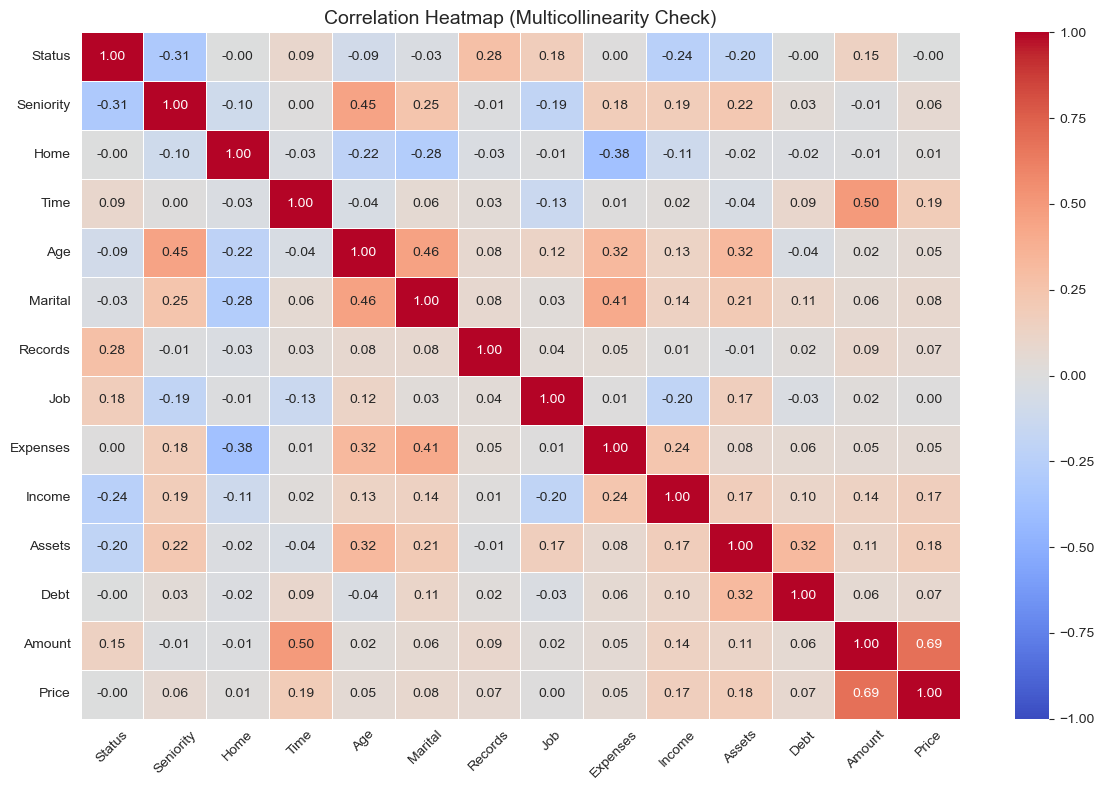

In [83]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,      # Show correlation values
    fmt=".2f",       # Format to 2 decimal places
    cmap="coolwarm", # Red (positive) vs. Blue (negative)
    vmin=-1,         # Min correlation value
    vmax=1,          # Max correlation value
    linewidths=0.5,
    cbar=True
)
plt.title("Correlation Heatmap (Multicollinearity Check)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

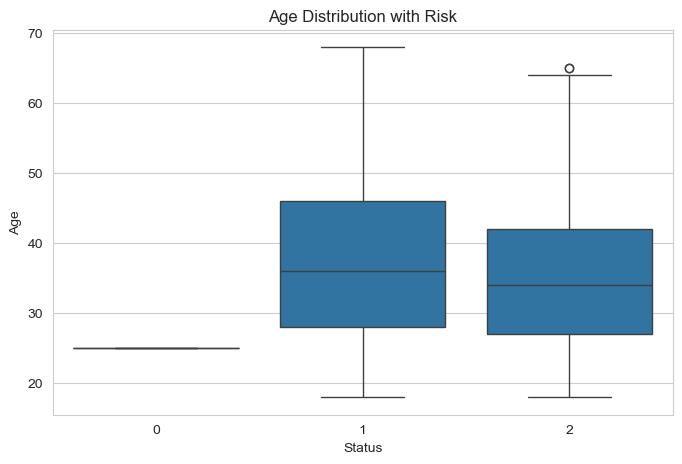

In [84]:
fig, ax = plt.subplots(figsize=(8, 5))  # Adjusted figsize for a single plot
sns.boxplot(data=Data, x='Status', y='Age', ax=ax).set_title("Age Distribution with Risk")
plt.show()

<Axes: ylabel='Price'>

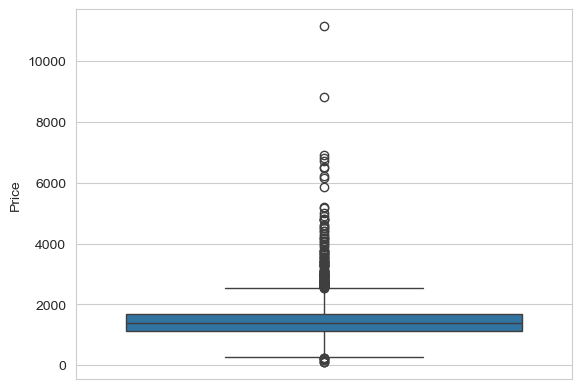

In [85]:
sns.boxplot(df['Price'])

In [58]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Price'] < (Q1 - 1.5*IQR)) | (df['Price'] > (Q3 + 1.5*IQR))]

In [86]:
print(outliers)

      Status  Seniority  Home  Time  Age  Marital  Records  Job  Expenses  \
2          2         10     2    36   46        2        2    3        90   
27         1         15     2    36   43        2        1    1        75   
100        1         38     2    48   57        2        1    3        45   
125        1         12     2    48   35        4        1    3        45   
142        1         15     2    24   54        2        1    3        90   
...      ...        ...   ...   ...  ...      ...      ...  ...       ...   
4386       1          7     2    60   28        2        1    1        45   
4392       2          3     2    60   35        2        2    1        60   
4411       1         40     2    36   58        2        1    3        45   
4414       2          5     2    60   30        2        2    3        45   
4423       2          1     1    60   37        4        2    2        66   

      Income  Assets  Debt  Amount  Price  
2        200    3000     0    2

In [4]:
#Status — whether the customer managed to pay back the loan (1) or not (2)
#• Seniority — job experience in years
#• Home — the type of homeownership: renting (1), a homeowner (2), and others.
#• Time — period planned for the loan (in months).
#• Age — the age of the client.
#• Marital [status] — single (1), married (2), and others.
#• Records — whether the client has any previous records: no (1), yes (2)2.
#• Job — the type of job: full-time (1), part-time (2), and others.
#• Expenses — how much the client spends per month.
#• Income — how much the client earns per month.
#• Assets — the total worth of all the assets of the client.
#• Debt — the amount of credit debt.
#• Amount — the requested amount of the loan.
#• Price — the price of an item the client wants to buy.


#First, Convert categorical variables from numbers to text to make sense of  status, home, marital, #job are in numbers

In [87]:
Data.columns = Data.columns.str.lower()

In [88]:
Data.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [99]:
print(Data.shape)

(4455, 14)


In [89]:
def label_encoding(df):
    status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
    }

    home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
    }

    marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
    }

    records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
    }

    job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
    }

    df.status = df.status.map(status_values)
    df.home = df.home.map(home_values)
    df.marital = df.marital.map(marital_values)
    df.records = df.records.map(records_values)
    df.job = df.job.map(job_values)


In [90]:
Data.describe().round()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,1.0,8.0,3.0,46.0,37.0,2.0,1.0,2.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,0.0,8.0,2.0,15.0,11.0,1.0,0.0,1.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,0.0,0.0,6.0,18.0,0.0,1.0,0.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,1.0,2.0,2.0,36.0,28.0,2.0,1.0,1.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,1.0,5.0,2.0,48.0,36.0,2.0,1.0,1.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,2.0,12.0,4.0,60.0,45.0,2.0,1.0,3.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,2.0,48.0,6.0,72.0,68.0,5.0,2.0,4.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [91]:
Data.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [92]:
Data.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [77]:
#label_encoding(Data)

In [93]:
#Remove unknown, not clear what to do with it
Data = Data[Data.status != 'unk']
Data.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
X = Data.drop(columns=['status'])
y = Data['status']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Verify shapes
print(f"X_train shape: {X_train.shape}")  # (samples, features)
print(f"X_test shape: {X_test.shape}")    # (samples, features)
print(f"y_train shape: {y_train.shape}")  # (samples,)
print(f"y_test shape: {y_test.shape}")    # (samples,)

X_train shape: (3564, 13)
X_test shape: (891, 13)
y_train shape: (3564,)
y_test shape: (891,)


In [100]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [107]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

In [101]:
importances = clf.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

      Feature  Gini Importance
8      income         0.148275
12      price         0.117511
0   seniority         0.117505
11     amount         0.114587
3         age         0.097596
9      assets         0.079701
5     records         0.065275
7    expenses         0.065271
6         job         0.053878
2        time         0.045151
1        home         0.041237
10       debt         0.031633
4     marital         0.022380


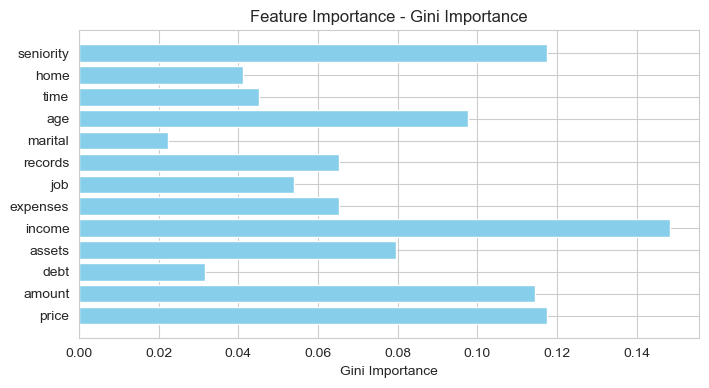

In [102]:
# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [73]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(Data, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)
y_train = (df_train.status == 'default').astype('int').values
df_train.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
2815,2,3,1,36,61,2,1,1,41,57,12000,0,2500,3559
1461,2,5,1,48,30,4,2,2,39,41,0,0,1300,1600
2935,1,15,2,60,32,5,1,3,35,0,6000,3300,1550,1612
1312,2,2,1,12,47,2,2,1,103,426,0,0,350,450
688,2,6,5,48,32,1,2,1,35,85,0,0,1100,1330


In [15]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
df_train.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,default,10,owner,36,36,married,no,freelance,75,0,10000,0,1000,1400
1,default,6,parents,48,32,single,yes,fixed,35,85,0,0,1100,1330
2,ok,1,parents,48,40,married,no,fixed,75,121,0,0,1320,1600
3,default,1,parents,48,23,single,no,partime,35,72,0,0,1078,1079
4,ok,5,owner,36,46,married,no,freelance,60,100,4000,0,1100,1897


In [18]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [19]:
del df_train['status']
del df_val['status']
del df_test['status']

In [20]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [21]:
def assess_risk(client):
    if client['records'] == 'yes':
      if client['job'] == 'parttime':
          return 'default'
      else:
          return 'ok'
    else:
      if client['assets'] > 6000:
          return 'ok'
      else:
          return 'default'

In [22]:
xi = df_train.iloc[0].to_dict()

In [23]:
xi = df_train.iloc[0].to_dict()
assess_risk(xi)

'ok'

In [23]:
#Decision tree classifier for binarey classification
#Categorical variables use dictionary vectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [24]:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

In [25]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [28]:
from sklearn.tree import export_text
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- seniority <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- seniority >  0.50
|   |   |   |   |--- price <= 925.00
|   |   |   |   |   |--- debt <= 100.00
|   |   |   |   |   |   |--- amount <= 387.50
|   |   |   |   |   |   |   |--- price <= 487.50
|   |   |   |   |   |   |   |   |--- home=owner <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- home=owner >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- price >  487.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- amount >  387.50
|   |   |   |   |   |   |   |--- expenses <= 97.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- expenses >  97.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- debt >  100.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- p

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)

In [30]:
print('train auc', auc)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('validation auc', auc)

train auc 1.0
validation auc 0.6378115085611877


In [31]:
# In both notebooks, run:
import sys
print(sys.executable)  # Should show same Python path

/opt/anaconda3/envs/ml_credit_scoring/bin/python
